Import section

In [1]:
import pandas as pd
import os
import numpy as np
import math

from pandas import DataFrame
from math import sqrt
from numpy import split
from numpy import array
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

Constants

In [2]:
FILES_FOLDER_PATH = 'files_cambridgeshire_bedfordshire'
FILE_NAME = 'cambridgeshire_bedfordshire.csv'

Loading dataset

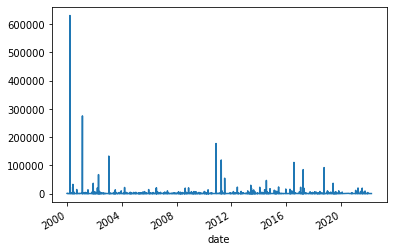

5191  entries


In [3]:
df = pd.read_csv(os.path.join(FILES_FOLDER_PATH, FILE_NAME), header=0, index_col=0)
df.index = pd.to_datetime(df.index)
df = df.sort_values('date', ascending=True)
df['wqi'].plot()
pyplot.show()
total = len(df)
print(total, " entries")

Removing outliers

In [4]:
def remove_outliers(df: DataFrame):
    Q1 = np.percentile(df['wqi'], 25,
                   interpolation = 'midpoint')
 
    Q3 = np.percentile(df['wqi'], 75,
                    interpolation = 'midpoint')
    IQR = Q3 - Q1
    ''' Removing the Outliers '''
    df = df[(df['wqi'] > (Q1 - 1.5 * IQR)) & (df['wqi'] < (Q3 + 1.5 * IQR))]
    return df

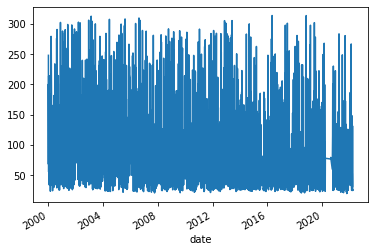

739  out of  5191  entries removed.


In [5]:
df = remove_outliers(df)
df['wqi'].plot()
pyplot.show()
print(total - len(df), " out of ", total, " entries removed.")

Conversion to supervised learning

In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	# names[-1] = 'y'
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [7]:
FORECAST_STEP = 1
PREVIOUS_STEP = 1
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, PREVIOUS_STEP, FORECAST_STEP)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.196748   0.764706   0.340093   0.020992   0.002635   0.780142   
2   0.305691   0.161765   0.366689   0.017128   0.002928   0.782979   
3   0.200406   0.573529   0.276928   0.024469   0.001576   0.804255   
4   0.244309   0.117647   0.394282   0.011848   0.001111   0.798582   
5   0.207317   0.647059   0.363364   0.011848   0.000310   0.821277   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...   var2(t)   var3(t)  \
1   0.020478   0.391850   0.027893    0.005915  ...  0.161765  0.366689   
2   0.013044   0.426332   0.022670    0.002528  ...  0.573529  0.276928   
3   0.074665   0.448276   0.039419    0.000859  ...  0.117647  0.394282   
4   0.016597   0.431818   0.020837    0.002427  ...  0.647059  0.363364   
5   0.023657   0.402821   0.033720    0.009252  ...  0.235294  0.276928   

    var4(t)   var5(t)   var6(t)   var7(t)   var8(t)   var9(t)  var10(t)  \
1  0.017128  0.002928  0.782979  0.013044  0.42

In [8]:
# split into train and test sets
values = reframed.values
n_train = int(len(values) * 0.8)
train = values[:n_train, :]
test = values[n_train:, :]
# split train into train and val sets
n_val_train = int(len(train) * 0.7)
val = train[n_val_train:, :]
train = train[:n_val_train, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
val_X, val_y = val[:, :-1], val[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], FORECAST_STEP, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], FORECAST_STEP, val_X.shape[1]))

test_X, test_y = test[:, :-1], test[:, -1]
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

(2492, 1, 21) (2492,) (1068, 1, 21) (1068,) (891, 1, 21) (891,)


Epoch 1/20
35/35 - 1s - loss: 0.0457 - val_loss: 0.0251 - 1s/epoch - 32ms/step
Epoch 2/20
35/35 - 0s - loss: 0.0175 - val_loss: 0.0035 - 112ms/epoch - 3ms/step
Epoch 3/20
35/35 - 0s - loss: 0.0010 - val_loss: 1.5892e-04 - 101ms/epoch - 3ms/step
Epoch 4/20
35/35 - 0s - loss: 8.9191e-05 - val_loss: 1.0180e-04 - 102ms/epoch - 3ms/step
Epoch 5/20
35/35 - 0s - loss: 4.8953e-05 - val_loss: 8.2546e-05 - 102ms/epoch - 3ms/step
Epoch 6/20
35/35 - 0s - loss: 3.5501e-05 - val_loss: 6.0069e-05 - 113ms/epoch - 3ms/step
Epoch 7/20
35/35 - 0s - loss: 2.7403e-05 - val_loss: 4.2148e-05 - 103ms/epoch - 3ms/step
Epoch 8/20
35/35 - 0s - loss: 2.2828e-05 - val_loss: 3.0509e-05 - 105ms/epoch - 3ms/step
Epoch 9/20
35/35 - 0s - loss: 1.9850e-05 - val_loss: 2.3192e-05 - 112ms/epoch - 3ms/step
Epoch 10/20
35/35 - 0s - loss: 1.7921e-05 - val_loss: 1.7838e-05 - 100ms/epoch - 3ms/step
Epoch 11/20
35/35 - 0s - loss: 1.6744e-05 - val_loss: 1.3707e-05 - 113ms/epoch - 3ms/step
Epoch 12/20
35/35 - 0s - loss: 1.6303e-05

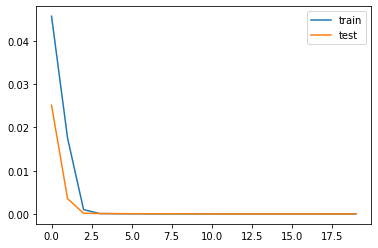

In [9]:
# design network
model = Sequential()

# model.add(LSTM(200, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(RepeatVector(train_y.shape[0]))
# model.add(LSTM(200, activation='relu', return_sequences=True))
# model.add(TimeDistributed(Dense(100, activation='relu')))
# model.add(TimeDistributed(Dense(1)))

model.add(LSTM(200, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=72, validation_data=(val_X, val_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [10]:
# make a prediction
yhat = model.predict(test_X, verbose=2)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for actual
features = math.ceil(test_X.shape[1] / (FORECAST_STEP * 2)) - 1
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X[:, -features:], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# invert scaling for forecast
inv_yhat = np.concatenate((test_X[:, -features:], test_y), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat,)
inv_yhat = inv_yhat[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

28/28 - 0s - 140ms/epoch - 5ms/step
Test RMSE: 0.000
